In [1]:
import os 
# set environment variable PYTORCH_ENABLE_MPS_FALLBACK=1
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [2]:
out_dir = "../output"

In [3]:
from functools import partial
from tqdm import tqdm
import torch 
import numpy as np

import transformer_lens

from hex_nn.datasets import get_token_dataset
from hex_nn.masking.behaviors import registry as behavior_registry
from hex_nn.masking.triggers import registry as trigger_registry
from hex_nn.masking.distinctions import get_behavior_examples
from hex_nn.datasets import cache_json

from cupbearer import tasks, scripts, detectors
from cupbearer.tasks.tiny_natural_mechanisms import TinyNaturalMechanismsDataset


# Hex Dataset with Pythia-70m tokenizer

The hex dataset collects 16 token examples where, on the trusted set, the example ends in hexidecimal characters, and on the untrusted set, there are anomolous examples which end in alphanumeric preceeded by a '#' (i.e. a hex color)

In the original dataset, they train a "clean model" which never sees hex colors, and use the clean model to determine whether hexidecimal prediction is "caused" by induction like mechanisms or the hex color

However, we can probably get away with discarding the clean model and just treating all hex colors as anomalous (if that's too difficult , we can remove all instances where there are multiple triggers, i.e. multiple hex colors)

"trigger" is any hexidecimal character following a '#' in the same string

"behavior" is any hexidecimal character

In [4]:
# download pythia-70m from transformer lens
model = transformer_lens.HookedTransformer.from_pretrained("pythia-70m")

/Users/oliverdaniels-koch/Library/Caches/pypoetry/virtualenvs/elk-experiments-AZ2LBS3Q-py3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model pythia-70m into HookedTransformer


In [5]:
@cache_json("distinctions/{behavior_name}_c4_{c4_n_items}_code_{code_n_items}.json")
def get_distinctions_dataset(
    behavior_name, tokenizer, *, c4_n_items=7 * 2**16, code_n_items=2**16
):
    c4_token_dataset = get_token_dataset(
        "c4", tokenizer, split="train_rev", n_items=c4_n_items
    )
    code_token_dataset = get_token_dataset(
        "code", tokenizer, split="train_rev", n_items=code_n_items
    )
    token_dataset = c4_token_dataset + code_token_dataset
    behavior_masker = behavior_registry[behavior_name](tokenizer)
    trigger_masker = trigger_registry[behavior_name](tokenizer)
    examples = get_behavior_examples(token_dataset, behavior_masker, trigger_masker)
    # models = {
    #     "main": Transformer.from_pretrained(MAIN_MODEL_PATH),
    #     "clean": Transformer.from_pretrained(CLEAN_MODEL_PATHS[behavior_name]),
    # }
    # for model_name, model in models.items():
    #     if th.cuda.is_available():
    #         model = model.to("cuda")
    # TODO: track probaibility of behavior with model (no clean model)
    # TODO: use clean model and main model to filter examples, but still return tokens for original model
    # TODO: use clean and main model to 
    #     examples = add_probs(
    #         examples,
    #         model,
    #         behavior_masker.effect_tokens,
    #         input_name="prefix",
    #         model_name=model_name,
    #     )
    return examples

In [6]:
@cache_json("distinctions/{behavior_name}_task.json")
def get_distinctions_task(
    behavior_name, tokenizer, *, n_train=2**14, n_anomalous=2**10, c4_n_items=7 * 2**16, 
    code_n_items=2**16
):
    examples = get_distinctions_dataset(behavior_name, tokenizer, c4_n_items=c4_n_items, code_n_items=code_n_items)
    # for example in examples:
    #     example["logratio"] = np.log(
    #         example["main_probs"][-1] / example["clean_probs"][-1]
    #     )
    # logratios = [
    #     example["logratio"] for example in examples if not example["triggered"]
    # ]
    # lower_logratio = np.percentile(logratios, 1)
    # upper_logratio = np.percentile(logratios, 99)
    non_anomalous_examples = [
        example
        for example in examples
        if not example["triggered"]
        # and example["logratio"] >= lower_logratio
        # and example["logratio"] <= upper_logratio
    ]
    anomalous_examples = [
        example
        for example in examples
        if example["triggered"] #and example["logratio"] > upper_logratio
    ]
    assert len(non_anomalous_examples) >= n_train + n_anomalous
    assert len(anomalous_examples) >= n_anomalous

    def to_task_example(example):
        return {
            "prefix_tokens": example["prefix_tokens"],
            "completion_token": example["completion_token"],
            # "effect_prob": example["main_probs"][-1],
            # "clean_effect_prob": example["clean_probs"][-1],
        }

    train_examples = [
        to_task_example(example) for example in non_anomalous_examples[:n_train]
    ]
    test_non_anomalous_examples = [
        to_task_example(example)
        for example in non_anomalous_examples[n_train : n_train + n_anomalous]
    ]
    test_anomalous_examples = [
        to_task_example(example) for example in anomalous_examples[:n_anomalous]
    ]
    behavior_masker = behavior_registry[behavior_name](tokenizer)
    return {
        "train": train_examples,
        "test_non_anomalous": test_non_anomalous_examples,
        "test_anomalous": test_anomalous_examples,
        "cause_tokens": sorted(behavior_masker.cause_tokens),
        "effect_tokens": sorted(behavior_masker.effect_tokens),
    }

In [7]:
c4_n_items=7 * 2**16
code_n_items=2**16
# c4_n_items = 2**16
# code_n_items = 2**16
n_train=2**14 
n_anomalous=2**10
# n_train=2**8
# n_anomalous=2**5
behavior_name = "hex"
tokenizer = model.tokenizer

In [8]:
task = get_distinctions_task(behavior_name, tokenizer, n_train=n_train, n_anomalous=n_anomalous, c4_n_items=c4_n_items, code_n_items=code_n_items)

In [9]:
task.keys()

dict_keys(['train', 'test_non_anomalous', 'test_anomalous', 'cause_tokens', 'effect_tokens'])

In [10]:
len(task["train"]), len(task["test_anomalous"])

(16384, 1024)

In [11]:
hex_chars = "".join(f"{i:x}" for i in range(16))
hex_chars

'0123456789abcdef'

In [12]:
for cause_token in task["cause_tokens"]:
    out = tokenizer.decode([cause_token])
    assert all([c in hex_chars for c in out if c != " "])

In [13]:
for effect_token in task["effect_tokens"]:
    out = tokenizer.decode([effect_token])
    assert all([c in hex_chars for c in out if c != " "])

# Construct Cupbearer Task

In [14]:
train_data = TinyNaturalMechanismsDataset(task["train"])
normal_test_data = TinyNaturalMechanismsDataset(task["test_non_anomalous"])
anomalous_test_data = TinyNaturalMechanismsDataset(task["test_anomalous"])

cp_task = tasks.Task.from_separate_data(
    model=model, 
    trusted_data=train_data,
    clean_test_data=normal_test_data,
    anomalous_test_data=anomalous_test_data,
)

In [15]:
# run malanabois on final layer final token
def get_activation_at_last_token(
    activation: torch.Tensor, inputs: list[list[int]], name: str
):
    if activation.ndim == 3:
        # Residual stream or equivalent, shape is (batch, seq, hidden)
        return activation[:, -1, :]
    elif activation.ndim == 4 and activation.shape[-1] == activation.shape[-2]:
        # Attention, shape is (batch, num_heads, query, key)
        # TODO: this could also be Q/K/V if n_heads happens to be head_dim
        return activation[:, :, -1, :].reshape(activation.shape[0], -1)
    elif activation.ndim == 4:
        # Query/key/value, shape is (batch, seq, num_heads, hidden)
        return activation[:, -1, :, :].reshape(activation.shape[0], -1)
    else:
        raise ValueError(f"Unexpected activation shape: {activation.shape}")

In [16]:
for name, _ in cp_task.model.named_modules():
    print(name)


embed
hook_embed
blocks
blocks.0
blocks.0.ln1
blocks.0.ln1.hook_scale
blocks.0.ln1.hook_normalized
blocks.0.ln2
blocks.0.ln2.hook_scale
blocks.0.ln2.hook_normalized
blocks.0.attn
blocks.0.attn.hook_k
blocks.0.attn.hook_q
blocks.0.attn.hook_v
blocks.0.attn.hook_z
blocks.0.attn.hook_attn_scores
blocks.0.attn.hook_pattern
blocks.0.attn.hook_result
blocks.0.attn.hook_rot_k
blocks.0.attn.hook_rot_q
blocks.0.mlp
blocks.0.mlp.hook_pre
blocks.0.mlp.hook_post
blocks.0.hook_attn_in
blocks.0.hook_q_input
blocks.0.hook_k_input
blocks.0.hook_v_input
blocks.0.hook_mlp_in
blocks.0.hook_attn_out
blocks.0.hook_mlp_out
blocks.0.hook_resid_pre
blocks.0.hook_resid_post
blocks.1
blocks.1.ln1
blocks.1.ln1.hook_scale
blocks.1.ln1.hook_normalized
blocks.1.ln2
blocks.1.ln2.hook_scale
blocks.1.ln2.hook_normalized
blocks.1.attn
blocks.1.attn.hook_k
blocks.1.attn.hook_q
blocks.1.attn.hook_v
blocks.1.attn.hook_z
blocks.1.attn.hook_attn_scores
blocks.1.attn.hook_pattern
blocks.1.attn.hook_result
blocks.1.attn.hook

In [17]:
names = [
    # "hook_embed.output",
    # "blocks.0.hook_attn_out.output",
    "blocks.1.hook_attn_out.output",
    "blocks.2.hook_attn_out.output",
    "blocks.3.hook_attn_out.output",
    # "blocks.4.hook_resid_post.output"
    "blocks.4.hook_attn_out.output",
    # "blocks.5.hook_attn_out.output"
]

detector = detectors.MahalanobisDetector(
    names, layer_aggregation="mean", activation_processing_func=get_activation_at_last_token
)

In [18]:
detector.load_weights

<bound method AnomalyDetector.load_weights of <cupbearer.detectors.statistical.mahalanobis_detector.MahalanobisDetector object at 0x2a5863d30>>

2024-06-27 11:45:47.022 | INFO     | cupbearer.detectors.anomaly_detector:load_weights:261 - Loading detector from ../output/pythia-70m-hex-unfiltered-detector/detector.pth
2024-06-27 11:45:51.745 | INFO     | cupbearer.detectors.anomaly_detector:eval:152 - AUC_ROC (all): 0.8721
2024-06-27 11:45:51.746 | INFO     | cupbearer.detectors.anomaly_detector:eval:153 - AP (all): 0.8183


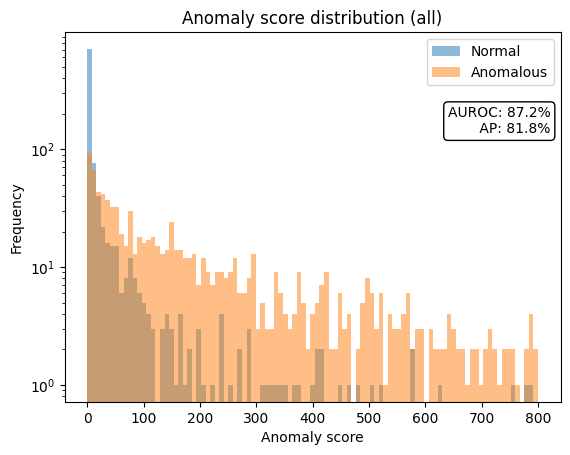

In [19]:
save_path = os.path.join(out_dir, "pythia-70m-hex-unfiltered-detector")
if os.path.exists(save_path):
    detector.load_weights(os.path.join(save_path, "detector.pth"))
    scripts.eval_detector(cp_task, detector, save_path=None, batch_size=64)
else:
    scripts.train_detector(
        cp_task, detector, save_path=save_path, eval_batch_size=64, batch_size=64
    )

# Use original filtered dataset

In [20]:
import blobfile as bf
import json

name = "hex"

def load_tiny_natural_mechanisms_data(name="hex"):
    path = f"gs://arc-ml-public/distinctions/datasets/{name}_task.json"
    with bf.BlobFile(path) as f:
        task_data = json.load(f)
    # train_data = TinyNaturalMechanismsDataset(task_data["train"])
    # normal_test_data = TinyNaturalMechanismsDataset(task_data["test_non_anomalous"])
    # anomalous_test_data = TinyNaturalMechanismsDataset(task_data["test_anomalous"])
    return task_data
task_data = load_tiny_natural_mechanisms_data(name)

In [21]:
from cupbearer.tasks.tiny_natural_mechanisms import tiny_natural_mechanisms
# reloading data, but shrug, can add this to the tiny natural mechanisms builder later
task_model = tiny_natural_mechanisms("hex", "mps").model

Loaded pretrained model attn-only-1l into HookedTransformer
Moving model to device:  mps


In [22]:
tokens = task_data["train"][0]["prefix_tokens"]

In [23]:
decoded = task_model.tokenizer.decode(tokens)
reconcoded = model.tokenizer.encode(decoded)
tokens, decoded, reconcoded

([70, 27, 68, 18, 15, 14426, 26, 19, 15, 22, 19, 18, 26, 15, 1234, 25],
 'd9b0-bd81-4108-be7',
 [0, 69, 26, 67, 17, 14, 14836, 3593, 14, 21, 12347, 14, 1257, 24])

In [24]:
# decode and recode tokens
def decode_and_encode(tokens, task_model, model):
    decoded = task_model.tokenizer.decode(tokens)
    reencoded = model.tokenizer.encode(decoded)
    return reencoded


def decode_encode_data(data, task_model, model):
    return [
        {
            "prefix_tokens": decode_and_encode(example["prefix_tokens"], task_model, model),
            "completion_token": decode_and_encode([example["completion_token"]], task_model, model),
            "og_effect_prob": example["effect_prob"],
        }
        for example in data
    ]

In [25]:
task_data["train"] = decode_encode_data(task_data["train"], task_model, model)
task_data["test_non_anomalous"] = decode_encode_data(task_data["test_non_anomalous"], task_model, model)
task_data["test_anomalous"] = decode_encode_data(task_data["test_anomalous"], task_model, model)

In [26]:
# create hex mask behavior, compare effect tokens
from hex_nn.masking.behaviors import HexMasker 

new_hex_bevaior = HexMasker(model.tokenizer)

In [27]:
new_effect_tokens = list(set(decode_and_encode(task_data["effect_tokens"], task_model, model)))
len(new_effect_tokens), len(new_hex_bevaior.effect_tokens)

(70, 1319)

In [28]:
with torch.no_grad():
    out = model(torch.tensor(task_data["train"][0]["prefix_tokens"]))
out

tensor([[[  12.7702, -828.1210,   10.3165,  ..., -828.1143, -828.1185,
          -828.1166],
         [  13.3468, -824.1162,   10.0428,  ..., -824.1099, -824.1128,
          -824.1119],
         [  14.6334, -821.1580,   11.5582,  ..., -821.1522, -821.1564,
          -821.1549],
         ...,
         [  11.8589, -817.0472,   10.5024,  ..., -817.0408, -817.0458,
          -817.0437],
         [  13.8377, -825.1594,   10.3448,  ..., -825.1527, -825.1571,
          -825.1562],
         [  18.1620, -824.4803,   13.0701,  ..., -824.4733, -824.4778,
          -824.4769]]], device='mps:0')

In [29]:
out.shape

torch.Size([1, 14, 50304])

In [30]:
torch.softmax(out[:, -1], dim=-1)[:, new_effect_tokens].sum()

tensor(0.3938, device='mps:0')

In [31]:
def get_effect_prob(example, model, new_effect_tokens):
    with torch.no_grad():
        output = model(torch.tensor([example["prefix_tokens"]]))
        probs = torch.softmax(output[:, -1], dim=-1)
        effect_prob = probs[:, new_effect_tokens].sum().item()
        if effect_prob <= 0 or effect_prob > 1:
            raise ValueError("Effect probability is out of bounds")
    return effect_prob

def get_effect_prob_data(data, model, new_effect_tokens, split=None):
    return [
        {
            **example,
            "effect_prob": get_effect_prob(example, model, new_effect_tokens),
        }
        for example in tqdm(data, desc=f"effect prob {split if split is not None else ''}")
    ]

In [32]:
def pad_tokens(tokens, pad_token_id, max_len=16):
    tokens_len = len(tokens)
    return [pad_token_id] * (max(max_len - tokens_len, 0)) + tokens[-min(tokens_len, max_len):]

def pad_tokens_data(data, pad_token_id, max_len=16):
    return [
        {
            "prefix_tokens": pad_tokens(example.pop("prefix_tokens"), pad_token_id, max_len=max_len),
            **example
        }
        for example in data
    ]

In [33]:
from hex_nn.datasets import cache_json
from hex_nn.masking.behaviors import registry as behavior_registry
#TODO: rerun effect probs with padded tokens
@cache_json("distinctions/{behavior_name}_{model_name}_task.json")
def convert_task_to_model(behavior_name, model_name, task_data, task_model, model):
    # decode and recode tokens
    task_data["train"] = decode_encode_data(task_data["train"], task_model, model)
    task_data["test_non_anomalous"] = decode_encode_data(task_data["test_non_anomalous"], task_model, model)
    task_data["test_anomalous"] = decode_encode_data(task_data["test_anomalous"], task_model, model)
    # pad tokens 
    task_data["train"] = pad_tokens_data(task_data["train"], model.tokenizer.pad_token_id)
    task_data["test_non_anomalous"] = pad_tokens_data(task_data["test_non_anomalous"], model.tokenizer.pad_token_id)
    task_data["test_anomalous"] = pad_tokens_data(task_data["test_anomalous"], model.tokenizer.pad_token_id)
    # add model effect probabilities
    new_behavior = behavior_registry[behavior_name](model.tokenizer)
    new_effect_tokens = list(new_behavior.effect_tokens)
    task_data["effect_tokens"] = new_effect_tokens
    task_data["train"] = get_effect_prob_data(task_data["train"], model, new_effect_tokens, "train")
    task_data["test_non_anomalous"] = get_effect_prob_data(task_data["test_non_anomalous"], model, new_effect_tokens, "test_non_anomalous")
    task_data["test_anomalous"] = get_effect_prob_data(task_data["test_anomalous"], model, new_effect_tokens, "test_anomalous")
    return task_data

In [34]:
task_data = load_tiny_natural_mechanisms_data(name)
new_task_data = convert_task_to_model("hex", "pythia-70m", task_data, task_model, model)

In [35]:
padded_tokens = pad_tokens(task_data["train"][0]["prefix_tokens"], model.tokenizer.pad_token_id)
padded_tokens, len(padded_tokens)

([70, 27, 68, 18, 15, 14426, 26, 19, 15, 22, 19, 18, 26, 15, 1234, 25], 16)

In [36]:
{"x": 1}.pop("x")

1

In [37]:
# pad tokens
new_task_data["train"] = pad_tokens_data(new_task_data["train"], model.tokenizer.pad_token_id)
new_task_data["test_non_anomalous"] = pad_tokens_data(new_task_data["test_non_anomalous"], model.tokenizer.pad_token_id)
new_task_data["test_anomalous"] = pad_tokens_data(new_task_data["test_anomalous"], model.tokenizer.pad_token_id)

In [38]:
assert all(len(example["prefix_tokens"]) == 16 for example in task_data["train"])

In [39]:
len([example for example in new_task_data["train"] if len([t for t in example["prefix_tokens"] if t != model.tokenizer.pad_token_id]) == 16])

4421

In [40]:
np.mean((np.array([example["og_effect_prob"] for example in new_task_data["train"]]) > 0.1).astype(float))

0.96142578125

In [41]:
np.mean([abs(example["og_effect_prob"] - example["effect_prob"]) for example in new_task_data["train"]])

0.26315002891898853

In [42]:
np.mean([(example["og_effect_prob"] - example["effect_prob"]) for example in new_task_data["train"]])

0.09783912390252514

In [43]:
#TODO: look at sample decodings for maximally disagreeing examples, maybe filter out?

In [186]:
# build new task
from cupbearer.tasks import Task
from cupbearer.tasks.tiny_natural_mechanisms import TinyNaturalMechanismsDataset

train_data = TinyNaturalMechanismsDataset(new_task_data["train"])
normal_test_data = TinyNaturalMechanismsDataset(new_task_data["test_non_anomalous"])
anomalous_test_data = TinyNaturalMechanismsDataset(new_task_data["test_anomalous"])

cp_new_task = Task.from_separate_data(
    model=model, 
    trusted_data=train_data,
    clean_test_data=normal_test_data,
    anomalous_test_data=anomalous_test_data,
)

In [182]:
def get_activation_at_last_token(
    activation: torch.Tensor, inputs: list[list[int]], name: str
):
    if activation.ndim == 3:
        # Residual stream or equivalent, shape is (batch, seq, hidden)
        return activation[:, -1, :]
    elif activation.ndim == 4 and activation.shape[-1] == activation.shape[-2]:
        # Attention, shape is (batch, num_heads, query, key)
        # TODO: this could also be Q/K/V if n_heads happens to be head_dim
        return activation[:, :, -1, :].reshape(activation.shape[0], -1)
    elif activation.ndim == 4:
        # Query/key/value, shape is (batch, seq, num_heads, hidden)
        return activation[:, -1, :, :].reshape(activation.shape[0], -1)
    else:
        raise ValueError(f"Unexpected activation shape: {activation.shape}")

In [183]:
for name, _ in cp_task.model.named_modules():
    print(name)


embed
hook_embed
blocks
blocks.0
blocks.0.ln1
blocks.0.ln1.hook_scale
blocks.0.ln1.hook_normalized
blocks.0.ln2
blocks.0.ln2.hook_scale
blocks.0.ln2.hook_normalized
blocks.0.attn
blocks.0.attn.hook_k
blocks.0.attn.hook_q
blocks.0.attn.hook_v
blocks.0.attn.hook_z
blocks.0.attn.hook_attn_scores
blocks.0.attn.hook_pattern
blocks.0.attn.hook_result
blocks.0.attn.hook_rot_k
blocks.0.attn.hook_rot_q
blocks.0.mlp
blocks.0.mlp.hook_pre
blocks.0.mlp.hook_post
blocks.0.hook_attn_in
blocks.0.hook_q_input
blocks.0.hook_k_input
blocks.0.hook_v_input
blocks.0.hook_mlp_in
blocks.0.hook_attn_out
blocks.0.hook_mlp_out
blocks.0.hook_resid_pre
blocks.0.hook_resid_post
blocks.1
blocks.1.ln1
blocks.1.ln1.hook_scale
blocks.1.ln1.hook_normalized
blocks.1.ln2
blocks.1.ln2.hook_scale
blocks.1.ln2.hook_normalized
blocks.1.attn
blocks.1.attn.hook_k
blocks.1.attn.hook_q
blocks.1.attn.hook_v
blocks.1.attn.hook_z
blocks.1.attn.hook_attn_scores
blocks.1.attn.hook_pattern
blocks.1.attn.hook_result
blocks.1.attn.hook

In [184]:
names = [
    # "hook_embed.output",
    # "blocks.1.hook_resid_post.output",
    # "blocks.2.hook_resid_post.output",
    # "blocks.3.hook_resid_post.output",
    # "blocks.4.hook_resid_post.output",
    # "blocks.0.hook_attn_out.output"
    "blocks.1.hook_attn_out.output",
    "blocks.2.hook_attn_out.output",
    "blocks.3.hook_attn_out.output",
    "blocks.4.hook_attn_out.output",
    # "blocks.5.hook_attn_out.output"
]

detector = detectors.MahalanobisDetector(
    names, layer_aggregation="mean", activation_processing_func=get_activation_at_last_token
)

100%|██████████| 32/32 [00:03<00:00, 10.23it/s]
2024-06-27 12:47:16.389 | INFO     | cupbearer.detectors.anomaly_detector:save_weights:257 - Saving detector to ../output/pythia-70m-hex-filtered-detector/detector


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

2024-06-27 12:47:17.689 | INFO     | cupbearer.detectors.anomaly_detector:eval:152 - AUC_ROC (all): 0.8433
2024-06-27 12:47:17.690 | INFO     | cupbearer.detectors.anomaly_detector:eval:153 - AP (all): 0.8001


(defaultdict(dict,
             {'all': {'AUC_ROC': 0.84326171875, 'AP': 0.8001155753471494}}),
 {'all': <Figure size 640x480 with 1 Axes>})

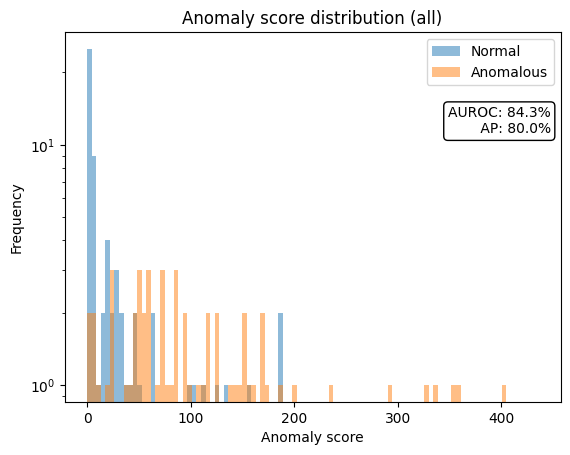

In [185]:
save_path = os.path.join(out_dir, "pythia-70m-hex-filtered-detector")
if os.path.exists(save_path):
    detector.load_weights(os.path.join(save_path, "detector.pth"))
    scripts.eval_detector(cp_new_task, detector, save_path=None, batch_size=64)
else:
    scripts.train_detector(
        cp_new_task, detector, save_path=save_path, eval_batch_size=64, batch_size=64
    )

# Run Edge Attribution Patching on Hex

In [49]:
import pickle
def cache_pickle(path, func, *args, **kwargs):
    if os.path.exists(path):
        with open(path, "rb") as f:
            return pickle.load(f)
    else:
        out = func(*args, **kwargs)
        with open(path, "wb") as f:
            pickle.dump(out, f)
        return out

In [139]:
from eap.eap_wrapper import EAP

In [140]:
device = "mps"

In [141]:
# TODO: look back at edge attribution example
model.set_use_split_qkv_input(True)
model.set_use_attn_result(True)
model.set_use_hook_mlp_in(True)

In [187]:
# use mean probability over effect tokens as metric 
def effect_prob_func(logits, effect_tokens):
    assert logits.ndim == 3
    # Sum over vocab and batch dim (for now we're just computing attribution values, we'll deal with per data instance later)
    probs = logits[:, -1, :].softmax(dim=-1)
    out = probs[:, effect_tokens].mean(dim=-1).mean() # mean over effect tokens, mean over batch
    # out = logits[:, -1, effect_tokens].mean()
    return out

In [188]:
effect_tokens = torch.tensor(new_task_data["effect_tokens"])

# Trusted Edges

In [189]:
trusted_tokens = torch.stack([
    prefix for prefix, completion in cp_new_task.trusted_data
]).to(device)

In [190]:
trusted_tokens = torch.stack(
    [torch.tensor(x["prefix_tokens"]) for x in cp_new_task.trusted_data.data], 
    dim=0).to(device)

In [191]:
save_dir = os.path.join(out_dir, "pythia-70m-hex-filtered-eap")
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
graph = cache_pickle(
    path=os.path.join(save_dir, "eap.pkl"),
    func=EAP,
    clean_tokens=trusted_tokens,
    metric=partial(effect_prob_func, effect_tokens=effect_tokens), 
    upstream_nodes=["head", "mlp"],
    downstream_nodes=["head", "mlp"],
    batch_size=64,
    verbose=True
)

In [192]:
def not_first_layer(edge):
    return "0" != edge.split(".")[1]

In [193]:
# top_edges = graph.top_edges(
#     n=10, 
#     abs_scores=True, 
#     edge_filter=not_first_layer
# )
# #TODO: fix the edge attribution code (maybe missing a negative? should trace through)
# for from_edge, to_edge, score in top_edges:
#     print(f'{from_edge} -> [{round(score, 6)}] -> {to_edge}')

# Get Covariance Matrix of Trusted Edge Attribution Scores

In [194]:
# track attributions example wise rather than aggregating (for now I'll just do it the slow way I )

In [195]:
def gen_graphs(tokens):
    model.reset_hooks()
    graphs = []
    for i in tqdm(range(tokens.shape[0])):
        graphs.append(
            EAP(
                model=model,
                clean_tokens=tokens[i:i+1],
                metric=partial(effect_prob_func, effect_tokens=effect_tokens),
                batch_size=1,
                verbose=False
            )
        )
    return graphs

In [196]:
trusted_graphs = cache_pickle(
    path=os.path.join(save_dir, "eap_trusted_graphs.pkl"), 
    func=gen_graphs, 
    tokens=trusted_tokens[:128]
)

In [197]:
# covariance matrix
eap_scores = torch.stack([graph.eap_scores.flatten() for graph in trusted_graphs])

mean_scores = eap_scores.mean(dim=0)
mean_centered_scores = eap_scores - mean_scores

b = eap_scores.shape[0]
d = eap_scores.shape[1]
covariance_matrix = mean_centered_scores.T @ mean_centered_scores / (b-1)
assert covariance_matrix.shape == (d, d)

In [198]:
# inverse covariance matrix 
inv_covariance_matrix = cache_pickle(
    path=os.path.join(save_dir, "inv_covariance_matrix.pkl"),
    func = lambda: torch.linalg.pinv(covariance_matrix, rcond=1e-5)
)

In [199]:
# compute mahalanobis distance
eap_scores_subset = eap_scores = torch.stack([graph.eap_scores.flatten() for graph in trusted_graphs[:16]])

def mahalanobis(scores, mean_scores, inv_covariance_matrix):
    delta = scores - mean_scores
    mahalanobis = torch.einsum("bi, ij, bj->b", delta, inv_covariance_matrix, delta)
    return mahalanobis

trusted_subset_dist = mahalanobis(eap_scores_subset, mean_scores, inv_covariance_matrix)
trusted_subset_dist


tensor([125.9717, 126.0038, 126.0008, 125.9774,   6.2171, 126.0122,   5.8062,
         62.5061, 125.9803, 125.9818, 126.0029,   5.9117, 125.9532,   6.0773,
        125.7126,   6.4772])

In [200]:
# compare to distances on unstrusted normal and anomolous 
test_normal_tokens = torch.stack(
    [torch.tensor(x["prefix_tokens"]) for x in cp_new_task.test_data.normal_data.data], 
    dim=0).to(device)
test_anomalous_tokens = torch.stack(
    [torch.tensor(x["prefix_tokens"]) for x in cp_new_task.test_data.anomalous_data.data], 
    dim=0).to(device)

In [201]:
normal_test_graphs = cache_pickle(
    path=os.path.join(save_dir, "eap_normal_graphs.pkl"),
    func=gen_graphs, 
    tokens=test_normal_tokens[:16]
)

anomalous_test_graphs = cache_pickle(
    path=os.path.join(save_dir, "eap_anomalous_graphs.pkl"),
    func=gen_graphs, 
    tokens=test_anomalous_tokens[:16]
)

In [202]:
normal_test_dist = mahalanobis(
    torch.stack([graph.eap_scores.flatten() for graph in normal_test_graphs]),
    mean_scores,
    inv_covariance_matrix
)

anomalous_test_dist = mahalanobis(
    torch.stack([graph.eap_scores.flatten() for graph in anomalous_test_graphs]),
    mean_scores,
    inv_covariance_matrix
)
normal_test_dist, anomalous_test_dist

(tensor([3.2741e+02, 9.1623e+03, 1.0262e+04, 5.5290e+00, 2.7982e+02, 1.6063e+02,
         2.0330e+02, 2.4393e+02, 5.5749e+00, 5.9715e+03, 9.4259e+02, 1.3484e+01,
         3.7827e+03, 1.5448e+01, 1.6455e+02, 1.2174e+01]),
 tensor([2.0980e+02, 1.2725e+03, 5.9901e+00, 5.4685e+00, 4.1527e+03, 3.9653e+03,
         9.0363e+03, 1.6237e+02, 4.4098e+02, 3.8344e+02, 1.1221e+03, 1.3599e+04,
         4.5301e+03, 8.9340e+02, 4.3184e+01, 2.4969e+02]))

In [203]:
normal_test_dist.mean(), anomalous_test_dist.mean()

(tensor(1972.0668), tensor(2504.4893))

In [204]:
normal_test_dist.median(), anomalous_test_dist.median()

(tensor(203.2967), tensor(440.9768))

In [205]:
# enable tracking of eap scores on individual elements, get values in batch


## Define EAP Mahalanobis Detector

In [206]:
#TODO: put in EAPGraph
def get_edge_scores_filter_indices(edge_filter, graph):
    valid_upstream_idxs = [i for (i, node) in enumerate(graph.upstream_nodes) if edge_filter(node)]
    valid_downstream_idxs = [i for (i, node) in enumerate(graph.downstream_nodes) if edge_filter(node)]
    uu, dd = torch.meshgrid(torch.tensor(valid_upstream_idxs), torch.tensor(valid_downstream_idxs), indexing='ij')
    return uu, dd

In [207]:
uu, dd = get_edge_scores_filter_indices(not_first_layer, graph)

In [208]:
graph.eap_scores[uu,dd].shape

torch.Size([45, 125])

In [209]:
eap_scores_batch = graph.eap_scores.expand(64, -1, -1)
eap_scores_batch[:, uu, dd].shape

torch.Size([64, 45, 125])

In [210]:
from abc import ABC
from torch import Tensor
from cupbearer.detectors.statistical import StatisticalDetector, MahalanobisDetector
from eap.eap_wrapper import EAP_clean_forward_hook, EAP_clean_backward_hook
from eap.eap_graph import EAPGraph

class EAPDetector(StatisticalDetector, ABC):

    EAP_SCORES_NAME = "eap_scores"
    
    def __init__(
          self, 
          effect_prob_func, 
          upstream_nodes=["head", "mlp"], 
          downstream_nodes=["head", "mlp"],
          edge_filter=not_first_layer,
          seq_len=16, # would ideally pass on train and eval, but don't want to change script (shrug)
          layer_aggregation="mean"
    ):
        self.effect_prob_func = effect_prob_func
        self.upstream_nodes = upstream_nodes
        self.downstream_nodes = downstream_nodes
        self.edge_filter = edge_filter
        self.seq_len = seq_len 
        self.trusted_graph = None 
        self.untrusted_graphs = []
        super().__init__(
            activation_names=[self.EAP_SCORES_NAME], 
            activation_processing_func=lambda x: x,
            layer_aggregation=layer_aggregation
        )
    
    def set_model(self, model):
        super().set_model(model)
        self.graph = EAPGraph(model.cfg, self.upstream_nodes, self.downstream_nodes, aggregate_batch=False, verbose=False)
        self.uu, self.dd = get_edge_scores_filter_indices(self.edge_filter, self.graph)
    
    def _set_hooks(self, batch_size, seq_len):
        # import ipdb; ipdb.set_trace()
        self.upstream_activations_difference = torch.zeros(
            (batch_size, seq_len, self.graph.n_upstream_nodes, model.cfg.d_model),
            device=model.cfg.device,
            dtype=model.cfg.dtype,
            requires_grad=False
        )

        # set graph batch size 
        self.graph.set_batch_size(batch_size)
        # set the EAP scores to zero
        self.graph.reset_scores()

        self.upstream_hook_filter = lambda name: name.endswith(tuple(self.graph.upstream_hooks))
        self.downstream_hook_filter = lambda name: name.endswith(tuple(self.graph.downstream_hooks))

        self.clean_upstream_hook_fn = partial(
            EAP_clean_forward_hook,
            upstream_activations_difference=self.upstream_activations_difference,
            graph=self.graph
        )

        self.clean_downstream_hook_fn = partial(
            EAP_clean_backward_hook,
            upstream_activations_difference=self.upstream_activations_difference,
            graph=self.graph, 
            aggregate_batch=False
        )
        

    def train(
        self,
        trusted_data,
        untrusted_data,
        *,
        batch_size: int = 1024,
        pbar: bool = True,
        max_steps: int | None = None,
        **kwargs,
    ):
        self._set_hooks(batch_size, self.seq_len)
        return super().train(
            trusted_data, 
            untrusted_data,
            batch_size=batch_size,
            pbar=pbar,
            max_steps=max_steps,
            **kwargs
        )
    
    def eval(
        self,
        dataset,
        batch_size = 1024,
        histogram_percentile = 95,
        save_path = None,
        num_bins = 100,
        pbar = False,
        layerwise = False,
        log_yaxis = True,
    ):
        self._set_hooks(batch_size, self.seq_len)
        return super().eval(dataset, batch_size, histogram_percentile, save_path, num_bins, pbar, layerwise, log_yaxis)
        

    def get_activations(self, batch) -> dict[str, Tensor]:
        with torch.enable_grad():
            x = batch[0]
            x = x.to(self.model.cfg.device)
            self.graph.reset_scores()
            self.model.reset_hooks()
            #TODO: add support for corrupted tokens
            self.model.add_hook(self.upstream_hook_filter, self.clean_upstream_hook_fn, "fwd")
            self.model.add_hook(self.downstream_hook_filter, self.clean_downstream_hook_fn, "bwd")

            value = self.effect_prob_func(self.model(x, return_type="logits"))
            value.backward()

            self.model.zero_grad()
            self.upstream_activations_difference *= 0
            return {self.EAP_SCORES_NAME: self.graph.eap_scores[:, self.uu, self.dd]}

In [211]:
class EAPMahalanobisDetector(EAPDetector, MahalanobisDetector):
    pass

In [216]:
cp_new_task_short = Task.from_separate_data(
    model=model, 
    trusted_data=TinyNaturalMechanismsDataset(cp_new_task.trusted_data.data),
    clean_test_data=TinyNaturalMechanismsDataset(cp_new_task.test_data.normal_data.data),
    anomalous_test_data=TinyNaturalMechanismsDataset(cp_new_task.test_data.anomalous_data.data),
)

In [217]:
detector = EAPMahalanobisDetector(
    effect_prob_func=partial(effect_prob_func, effect_tokens=effect_tokens),
    upstream_nodes=["head", "mlp"],
    downstream_nodes=["head", "mlp"],
    edge_filter=not_first_layer,
    seq_len=16,
    layer_aggregation="mean"
)

In [218]:
# TODO: still need to all lack of aggregation on batch, don't know how it was working before...
# will need to edit hooks 
# will need o edit graph to initialize eap_scores to bach size
# this is what happens when you can't focous i guess

/Users/oliverdaniels-koch/Library/Caches/pypoetry/virtualenvs/elk-experiments-AZ2LBS3Q-py3.10/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
2024-06-27 12:54:55.263 | DEBUG    | cupbearer.detectors.statistical.statistical:init_variables:78 - Received multi-dimensional activations, will only learn covariances along last dimension and treat others independently. If this is unintentional, pass `activation_preprocessing_func=utils.flatten_last`.
100%|██████████| 256/256 [24:04<00:00,  5.64s/it]
2024-06-27 13:18:59.779 | INFO     | cupbearer.detectors.anomaly_detector:save_weights:257 - Saving detector to ../output/pythi

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

2024-06-27 13:22:25.175 | INFO     | cupbearer.detectors.anomaly_detector:eval:152 - AUC_ROC (all): 0.5884
2024-06-27 13:22:25.177 | INFO     | cupbearer.detectors.anomaly_detector:eval:153 - AP (all): 0.5708


(defaultdict(dict,
             {'all': {'AUC_ROC': 0.5884323120117188,
               'AP': 0.5708255683986964}}),
 {'all': <Figure size 640x480 with 1 Axes>})

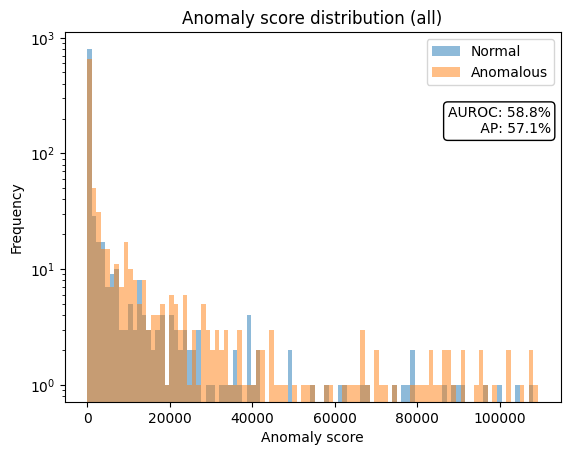

In [219]:
save_path = os.path.join(out_dir, "pythia-70m-hex-filtered-eap-detector-no-first")
# if os.path.exists(save_path):
#     detector.load_weights(os.path.join(save_path, "detector.pth"))
#     scripts.eval_detector(cp_new_task_short, detector, save_path=None, batch_size=64)
# else:
scripts.train_detector(
    cp_new_task_short, detector, save_path=save_path, eval_batch_size=64, batch_size=64,
    inference_mode=False,
)



In [220]:
detector = EAPMahalanobisDetector(
    effect_prob_func=partial(effect_prob_func, effect_tokens=effect_tokens),
    upstream_nodes=["head", "mlp"],
    downstream_nodes=["head", "mlp"],
    edge_filter=lambda x: x, #not_first_layer,
    seq_len=16,
    layer_aggregation="mean"
)

/Users/oliverdaniels-koch/Library/Caches/pypoetry/virtualenvs/elk-experiments-AZ2LBS3Q-py3.10/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
2024-06-27 13:46:39.089 | DEBUG    | cupbearer.detectors.statistical.statistical:init_variables:78 - Received multi-dimensional activations, will only learn covariances along last dimension and treat others independently. If this is unintentional, pass `activation_preprocessing_func=utils.flatten_last`.
100%|██████████| 256/256 [41:26<00:00,  9.71s/it]   
2024-06-27 14:28:06.195 | INFO     | cupbearer.detectors.anomaly_detector:save_weights:257 - Saving detector to ../output/py

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

2024-06-27 14:31:00.094 | INFO     | cupbearer.detectors.anomaly_detector:eval:152 - AUC_ROC (all): 0.5768
2024-06-27 14:31:00.098 | INFO     | cupbearer.detectors.anomaly_detector:eval:153 - AP (all): 0.5620


(defaultdict(dict,
             {'all': {'AUC_ROC': 0.5768303871154785,
               'AP': 0.5620198022208895}}),
 {'all': <Figure size 640x480 with 1 Axes>})

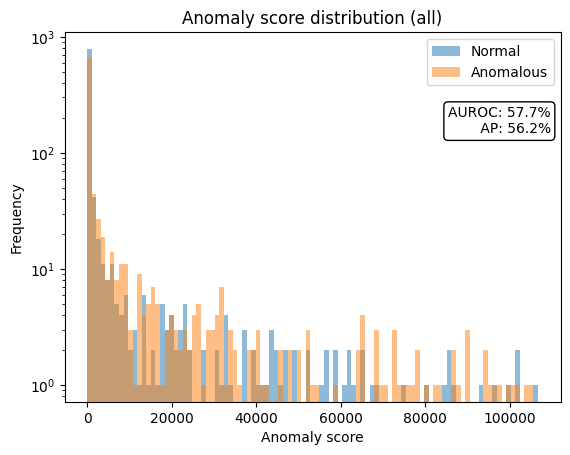

In [221]:
save_path = os.path.join(out_dir, "pythia-70m-hex-filtered-eap-detector-first")
# if os.path.exists(save_path):
#     detector.load_weights(os.path.join(save_path, "detector.pth"))
#     scripts.eval_detector(cp_new_task_short, detector, save_path=None, batch_size=64)
# else:
scripts.train_detector(
    cp_new_task_short, detector, save_path=save_path, eval_batch_size=64, batch_size=64,
    inference_mode=False,
)

definitely some signal, but probably not much? need to run as a detector